# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [6735]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [6737]:
#Функция для модификации столбца датафрейма после рассчета woe 
def change_column_woe_new(df1, col, dic):
    df1[col] = df1[col].astype(str)
    df1[col] = list(df1[col].map(dic))
    df1[col] = df1[col].astype(float)

In [6738]:
#Функция рассчета woe iv для признака
def calc_woe_iv(df_tr, col) :
    df = pd.DataFrame(columns = ['values','total','good','bad','event_rate','non_event_rate','per_total_events','per_total_non_events','WOE','IV'])
    df['values'] = df_tr[col].unique()
    df.set_index('values',inplace = True)
    
    values = df_tr[col].unique()
    total_dict = dict(df_tr.groupby(col).size())
    col_target_dict = dict(df_tr.groupby([col,'default_12m']).size())
    target_count = dict(df_tr.groupby(['default_12m']).size())
    
    for value in values :
        df.loc[value]['total'] = total_dict[value]
        if (value,1) in col_target_dict:
            df.loc[value]['good'] = col_target_dict[(value,1)]
        else :
            df.loc[value]['good'] = 0
        
        if (value,0) in col_target_dict:
            df.loc[value]['bad'] = col_target_dict[(value,0)]
        else :
            df.loc[value]['bad'] = 0
            
        if df.loc[value]['bad'] == 0 :
            df = df.drop([value])
        
    df['event_rate'] = df['good']/df['total']
    df['non_event_rate'] = df['bad']/df['total']
    
    df['per_total_events'] = df['good']/target_count[1]
    df['per_total_non_events'] = df['bad']/target_count[0]
    
    df['WOE'] = np.log(df.per_total_events.astype('float64')/df.per_total_non_events.astype('float64'))
    df['IV'] = (df['per_total_events'] - df['per_total_non_events']) * df['WOE']
    
    return df 

In [6740]:
#функция замены значений на woe df1(с пропусками)
def change_data_with_nan(df):
    bins1 = [-np.inf,35, 50, np.inf]
    labels1 = [ '1', '2', '3']
    df['bus_age_bin'] = pd.cut(df['bus_age'], bins = bins1, labels = labels1)
    change_column_woe_new(df, 'bus_age_bin', dict01)
    
    bins2 = [-np.inf, 46, 103, np.inf]
    labels2 = [ '1', '2', '3']
    df['ogrn_age_bin'] = pd.cut(df['ogrn_age'], bins = bins2, labels = labels2)
    change_column_woe_new(df, 'ogrn_age_bin', dict02)
    
    bins3 = [-np.inf, 3, 16,  np.inf]
    labels3 = [ '1', '2', '3']
    df['head_actual_age_bin'] = pd.cut(df['head_actual_age'], bins = bins3, labels = labels3)
    change_column_woe_new(df,'head_actual_age_bin', dict03)
    
    df['ul_staff_range_bin'] = df['ul_staff_range']
    df.loc[df['ul_staff_range_bin']==2, 'ul_staff_range_bin'] = 3
    df.loc[df['ul_staff_range_bin']==1, 'ul_staff_range_bin'] = 0.017748
    df.loc[df['ul_staff_range_bin']==3, 'ul_staff_range_bin'] = -0.714560
    
    bins5 = [-np.inf,40000,  np.inf]
    labels5 = [ '1', '2']
    df['ul_capital_sum_bin'] = pd.cut(df['ul_capital_sum'], bins = bins5, labels = labels5)
    change_column_woe_new(df, 'ul_capital_sum_bin', dict05)
    
    bins6 = [-np.inf,1, 4,  np.inf]
    labels6 = [ '1', '2', '3']
    df['ul_founders_cnt_bin'] = pd.cut(df['ul_founders_cnt'], bins = bins6, labels = labels6)
    change_column_woe_new(df, 'ul_founders_cnt_bin', dict06)
    df.drop(columns = ['bus_age', 'ogrn_age', 'head_actual_age', 'ul_staff_range', 'ul_capital_sum', 'ul_founders_cnt'], inplace = True)
    

In [6741]:
#функция замены значений на woe df1(без пропусков)
def change_data(df):
    
    df['CAP_AS_bin'] = pd.cut(df['CAP_AS'], bins = bins12, labels = labels12)
    change_column_woe_new(df, 'CAP_AS_bin', dict12)
   
    df['LIQ_ABS_bin'] = pd.cut(df['LIQ_ABS'], bins = bins15, labels = labels15)
    change_column_woe_new(df, 'LIQ_ABS_bin', dict15)
    
    df['LIQ_QUIK_bin'] = pd.cut(df['LIQ_QUIK'], bins = bins16, labels = labels16)
    change_column_woe_new(df, 'LIQ_QUIK_bin', dict16)

    df['coeff_likv_bin'] = pd.cut(df['coeff_likv'], bins = bins18, labels = labels18)
    change_column_woe_new(df, 'coeff_likv_bin', dict18)

    df['ar_revenue_bin'] = pd.cut(df['ar_revenue'], bins = bins20, labels = labels20)
    change_column_woe_new(df, 'ar_revenue_bin', dict20)
    
    df['ar_selling_expenses_bin'] = pd.cut(df['ar_selling_expenses'], bins = bins23, labels = labels23)
    change_column_woe_new(df, 'ar_selling_expenses_bin', dict23)

    df['ar_profit_before_tax_bin'] = pd.cut(df['ar_profit_before_tax'], bins = bins27, labels = labels27)
    change_column_woe_new(df, 'ar_profit_before_tax_bin', dict27)

    df['ar_taxes_bin'] = pd.cut(df['ar_taxes'], bins = bins28, labels = labels28)
    change_column_woe_new(df, 'ar_taxes_bin', dict28)

    df['bus_age_bin'] = pd.cut(df['bus_age'], bins = bins44, labels = labels44)
    change_column_woe_new(df, 'bus_age_bin', dict44)

    df['ul_capital_sum_bin'] = pd.cut(df['ul_capital_sum'], bins = bins48, labels = labels48)
    change_column_woe_new(df, 'ul_capital_sum_bin', dict48)

    df['ul_founders_cnt_bin'] = pd.cut(df['ul_founders_cnt'], bins = bins49, labels = labels49)
    change_column_woe_new(df, 'ul_founders_cnt_bin', dict49)

    df['head_actual_age_bin'] = pd.cut(df['head_actual_age'], bins = bins46, labels = labels46)
    change_column_woe_new(df, 'head_actual_age_bin', dict46)

    
    df.drop(columns = [ 'CAP_AS', 'LIQ_ABS', 'LIQ_QUIK',
                        'coeff_likv', 'ar_revenue', 'ar_total_expenses', 'ar_sale_cost',
                      'ar_selling_expenses', 'ar_management_expenses', 'ar_sale_profit',  
                      'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes', 
                      'ar_other_profit_and_losses', 'ar_net_profit', 'ab_immobilized_assets', 
                       'ab_mobile_current_assets', 'ab_inventory', 'ab_accounts_receivable', 
                       'ab_other_current_assets','ab_cash_and_securities', 'ab_losses',
                       'ab_own_capital', 'ab_borrowed_capital','ab_long_term_liabilities', 
                       'ab_short_term_borrowing', 'ab_accounts_payable', 
                 'ab_other_borrowings', 'bus_age', 
                      'ogrn_age', 'ul_staff_range', 'head_actual_age', 
                       'ul_capital_sum', 'ul_founders_cnt' , 'rashody', 
                       'oborotnie_activy' , 'activy_vsego','kratkosrochn_obyazatel',
                       'dolgosrochn_obyazat'], inplace = True)

### Подгружаем данные

In [6744]:
train_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-train.csv', sep=';')
test_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-test.csv', sep=';')
desc_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-desc.csv', sep=';')

Описание данных

In [6745]:
desc_df.head(2)

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год


Семплы и размеры выборок

In [6746]:
train_df.head(2)

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0


In [6747]:
test_df.head(2)

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,...,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138,5,5,5,[1-100],100000.0,1,0,0,0


In [6748]:
train_df.shape

(32395, 37)

In [6749]:
train_df.shape

(32395, 37)

Количество разных типов фичей

In [6750]:
train_df.dtypes.value_counts()

float64    25
int64      11
object      1
dtype: int64

Уровень дефолт-рейта в выборке = 6,4546%

In [6751]:
train_df['default_12m'].values.mean()

0.06454699799351751

32395 уникальных наблюдений

In [6752]:
train_df.record_id.nunique()

32395

### Строим бэйзлайн модель c 3-ми фичами

In [6753]:
features = ['bus_age','ul_capital_sum', 'ul_founders_cnt']
features_df = train_df.loc[:,features]
features_df['default_12m'] = train_df['default_12m']
features_df.head()

,bus_age,ul_capital_sum,ul_founders_cnt,default_12m
0,198,50000.0,2,0
1,256,10000.0,5,0
2,33,10000.0,2,0
3,185,300000.0,1,0
4,220,10000.0,2,0


Построим карту коллеряций

In [6754]:
features_df.corr()

,bus_age,ul_capital_sum,ul_founders_cnt,default_12m
bus_age,1.000000,0.066929,0.209451,-0.109389
ul_capital_sum,0.066929,1.000000,0.029165,-0.019452
ul_founders_cnt,0.209451,0.029165,1.000000,-0.023244
default_12m,-0.109389,-0.019452,-0.023244,1.000000


Валидация результата

In [6755]:
X_train, X_test, y_train, y_test = train_test_split(features_df.drop('default_12m',axis=1),
                                                    features_df['default_12m'],
                                                    random_state=42, shuffle=True)

logit = LogisticRegression(C=1,solver='lbfgs',max_iter=1000)
cv_baseline = cross_val_score(logit, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.6483643068016243

ROC/AUC бэйзлайн модели - 64,83%

# Анализ данных и работа с признаками

В датафрейме train_df есть 5805 дубликатов. Удалим их

In [6756]:
c = ['ar_revenue', 'ar_total_expenses', 'ar_sale_cost',
       'ar_selling_expenses', 'ar_management_expenses', 'ar_sale_profit',
       'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes',
       'ar_other_profit_and_losses', 'ar_net_profit', 'ab_immobilized_assets',
       'ab_mobile_current_assets', 'ab_inventory', 'ab_accounts_receivable',
       'ab_other_current_assets', 'ab_cash_and_securities', 'ab_losses',
       'ab_own_capital', 'ab_borrowed_capital', 'ab_long_term_liabilities',
       'ab_short_term_borrowing', 'ab_accounts_payable', 'ab_other_borrowings',
       'bus_age', 'ogrn_age', 'adr_actual_age', 'head_actual_age',
       'cap_actual_age', 'ul_staff_range', 'ul_capital_sum', 'ul_founders_cnt',
       'ul_branch_cnt', 'ul_strategic_flg', 'ul_systematizing_flg',
       'default_12m']
train_df = train_df.drop_duplicates(c)
26590+5805

32395

In [6757]:
train_df.shape

(26590, 37)

'ul_staff_range' - категориальный признак

In [6758]:
train_df['ul_staff_range'].value_counts()

[1-100]      23737
(100-500]     2519
> 500          334
Name: ul_staff_range, dtype: int64

In [6759]:
test_df['ul_staff_range'].value_counts()

[1-100]      184
(100-500]     12
> 500          4
Name: ul_staff_range, dtype: int64

In [6760]:
# категориальный признак
train_df.loc[train_df['ul_staff_range'] == '[1-100]', 'ul_staff_range'] = 1
train_df.loc[train_df['ul_staff_range'] == '(100-500]', 'ul_staff_range'] = 2 
train_df.loc[train_df['ul_staff_range'] == '> 500', 'ul_staff_range'] = 3

test_df.loc[test_df['ul_staff_range'] == '[1-100]', 'ul_staff_range'] = 1
test_df.loc[test_df['ul_staff_range'] == '(100-500]', 'ul_staff_range'] = 2 
test_df.loc[test_df['ul_staff_range'] == '> 500', 'ul_staff_range'] = 3
test_df['ul_staff_range'] = test_df['ul_staff_range'].astype(int)
train_df['ul_staff_range'] = train_df['ul_staff_range'].astype(int)

'ul_systematizing_flg' - в train_df и test_df во всех строчках значения равны нулю. Можно удалить столбец
'ul_strategic_flg' - в train_df 3 значения отличных от нуля, а в test_df все значения нули, Так же можно удалить 
'ul_branch_cnt' - в test_df все значения нули, в train_df около 300 значений, отличных от нуля, Так же можно удалить

In [6761]:
train_df['ul_strategic_flg'].value_counts(dropna = False)

0    26587
1        3
Name: ul_strategic_flg, dtype: int64

In [6762]:
test_df['ul_strategic_flg'].value_counts(dropna = False)

0    200
Name: ul_strategic_flg, dtype: int64

In [6763]:
train_df['ul_branch_cnt'].value_counts(dropna = False)

0     26278
1       206
2        40
3        19
5        11
4        11
6         7
10        6
8         5
12        3
20        2
11        1
17        1
Name: ul_branch_cnt, dtype: int64

In [6764]:
test_df['ul_branch_cnt'].value_counts(dropna = False)

0    200
Name: ul_branch_cnt, dtype: int64

In [6765]:
train_df.drop(columns = ['ul_systematizing_flg', 'ul_strategic_flg', 'ul_branch_cnt'], inplace = True)
test_df.drop(columns = ['ul_systematizing_flg', 'ul_strategic_flg', 'ul_branch_cnt'], inplace = True)

head_actual_age	, cap_actual_age , adr_actual_age дублируют друг друга и в train_df и test_df в  - удаляем два признака

In [6766]:
train_df[train_df['head_actual_age']==train_df['cap_actual_age']].shape

(26590, 34)

In [6767]:
test_df[test_df['head_actual_age']==test_df['cap_actual_age']].shape

(200, 33)

In [6768]:
train_df[train_df['head_actual_age']==train_df['adr_actual_age']].shape

(26590, 34)

In [6769]:
test_df[test_df['head_actual_age']==test_df['adr_actual_age']].shape

(200, 33)

In [6770]:
train_df.shape

(26590, 34)

In [6771]:
train_df.drop(columns = ['cap_actual_age', 'adr_actual_age'], inplace = True)
test_df.drop(columns = ['cap_actual_age', 'adr_actual_age'], inplace = True)

Обратим внимание на пропуски по столбцам с финансовыми показателями. Есть 10215 записей с пропусками в 24 столбцах в датафрейме train_df , и 118 записей в test_df
Разделим каждый из датафреймов на 2 части:
часть train_df1 и test_df1 - где есть пропуски,
часть train_df2 и test_df2 - где пропусков нет
Далее будем работать уже с 2 частями по отдельности

In [6772]:
train_df['ar_revenue'].value_counts(dropna=False)

NaN            10215
0.0              380
12318000.0        12
162663000.0       11
104513000.0       10
               ...  
295829000.0        1
480378000.0        1
4704000.0          1
296299000.0        1
587183000.0        1
Name: ar_revenue, Length: 12894, dtype: int64

In [6773]:
test_df['ar_revenue'].value_counts(dropna=False)

NaN           118
0.0             7
8373000.0       1
25234000.0      1
13383000.0      1
             ... 
39103000.0      1
59875000.0      1
58896000.0      1
25262000.0      1
140000.0        1
Name: ar_revenue, Length: 77, dtype: int64

In [6774]:
len(train_df) - train_df.count()

record_id                           0
ar_revenue                      10215
ar_total_expenses               10215
ar_sale_cost                    10215
ar_selling_expenses             10215
ar_management_expenses          10215
ar_sale_profit                  10215
ar_balance_of_rvns_and_expns    10215
ar_profit_before_tax            10215
ar_taxes                        10215
ar_other_profit_and_losses      10215
ar_net_profit                   10215
ab_immobilized_assets           10215
ab_mobile_current_assets        10215
ab_inventory                    10215
ab_accounts_receivable          10215
ab_other_current_assets         10215
ab_cash_and_securities          10215
ab_losses                       10215
ab_own_capital                  10215
ab_borrowed_capital             10215
ab_long_term_liabilities        10215
ab_short_term_borrowing         10215
ab_accounts_payable             10215
ab_other_borrowings             10215
bus_age                             0
ogrn_age    

In [6775]:
#train_df1 - часть df где  пропуски
train_df1 = train_df[train_df['ar_revenue'].isnull()]
train_df2 = train_df[train_df['ar_revenue'].notnull()]

test_df1 = test_df[test_df['ar_revenue'].isnull()]
test_df2 = test_df[test_df['ar_revenue'].notnull()]

In [6776]:
print(train_df2.shape[0] + train_df1.shape[0] - train_df.shape[0])
print(test_df2.shape[0] + test_df1.shape[0] - test_df.shape[0])

0
0


# df1

Оставим только столбцы без пропусков

In [6777]:
col_for_del =['ar_revenue', 'ar_total_expenses', 'ar_sale_cost',
       'ar_selling_expenses', 'ar_management_expenses', 'ar_sale_profit',
       'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes',
       'ar_other_profit_and_losses', 'ar_net_profit', 'ab_immobilized_assets',
       'ab_mobile_current_assets', 'ab_inventory', 'ab_accounts_receivable',
       'ab_other_current_assets', 'ab_cash_and_securities', 'ab_losses',
       'ab_own_capital', 'ab_borrowed_capital', 'ab_long_term_liabilities',
       'ab_short_term_borrowing', 'ab_accounts_payable', 'ab_other_borrowings']

In [6778]:
test_df1.drop(columns = col_for_del, inplace = True)
train_df1.drop(columns = col_for_del, inplace = True)
train_df1.drop(columns = ['record_id'], inplace = True)

In [6779]:
train_df1.describe()

,bus_age,ogrn_age,head_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,default_12m
count,10215.000000,10215.000000,10215.000000,10215.000000,1.021500e+04,10215.000000,10215.000000
mean,91.391483,75.833872,14.088693,1.038767,6.683238e+05,5.474596,0.102301
std,71.594633,45.095162,9.378940,0.230070,1.649400e+07,58.603881,0.303058
min,0.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000
25%,35.000000,35.000000,5.000000,1.000000,1.000000e+04,1.000000,0.000000
50%,73.000000,72.000000,13.000000,1.000000,1.000000e+04,1.000000,0.000000
75%,128.000000,123.000000,24.000000,1.000000,2.275000e+04,2.000000,0.000000
max,921.000000,147.000000,33.000000,3.000000,1.584979e+09,998.000000,1.000000


Разобьем датафрейм train_df1 на тестовую и валидационную часть

In [6780]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(train_df1.drop('default_12m',axis=1),
                                                    train_df1['default_12m'],
                                                    random_state=42, shuffle=True)

Перед обучением модели логистической регрессии необходимо выполнить преобразование признаков.
Можно делать нормализацию, стандартизацию и тд
В данном случае будем делать биннинг с рассчетом WOE и IV.
К сожалению, библиотек, которые делают эти операции от и до , я не нашла.
Поэтому использовала функцию для рассчета WOE и IV и дальше подбирала интервалы для разбиения следующим образом:
    - максимальное значение IV для интервала
    - линейная зависимость значения WOE от номера интервала разбиения
Это необходимо, чтобы не обрабатывать выборсы, чтобы убрать нелинейную зависимость признака и сделать модеть интерпретируемой

In [6781]:
train_df1_train = X_train1
train_df1_train['default_12m'] = y_train1

Binning

<AxesSubplot:>

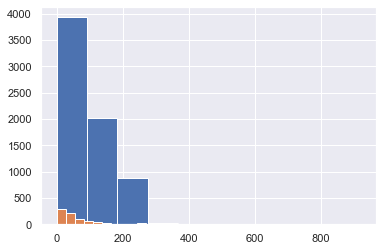

In [6782]:
train_df1_train[train_df1_train['default_12m']==0]['bus_age'].hist(bins = 10)
train_df1_train[train_df1_train['default_12m']==1]['bus_age'].hist(bins = 10)

In [6783]:
bins = [-np.inf,35, 50, np.inf]
labels = [ '1', '2', '3']
train_df1_train['bus_age_bin'] = pd.cut(train_df1_train['bus_age'], bins = bins, labels = labels)
d1 =calc_woe_iv(train_df1_train, 'bus_age_bin')
d1

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
2,855,122,733,0.14269,0.85731,0.155612,0.106587,0.378404,0.0185513
3,4920,311,4609,0.0632114,0.936789,0.396684,0.670205,-0.524445,0.143447
1,1886,351,1535,0.186108,0.813892,0.447704,0.223208,0.696029,0.156256


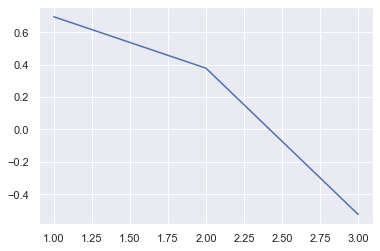

In [6784]:
dict01 = {'1': 0.696029, '2': 0.378404, '3':-0.524445 }
plt.plot([1, 2, 3], [0.696029, 0.378404,-0.524445 ])

<AxesSubplot:>

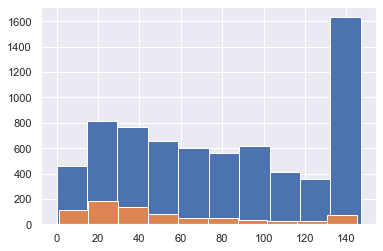

In [6785]:
train_df1_train[train_df1_train['default_12m']==0]['ogrn_age'].hist(bins = 10)
train_df1_train[train_df1_train['default_12m']==1]['ogrn_age'].hist(bins = 10)

In [6786]:
bins = [-np.inf, 46, 103, np.inf]
labels = [ '1', '2', '3']
train_df1_train['ogrn_age_bin'] = pd.cut(train_df1_train['ogrn_age'], bins = bins, labels = labels)
d2 =calc_woe_iv(train_df1_train,'ogrn_age_bin')
d2

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,2596,457,2139,0.17604,0.82396,0.582908,0.311037,0.628118,0.170767
2,2576,205,2371,0.0795807,0.920419,0.26148,0.344772,-0.276528,0.0230328
3,2489,122,2367,0.0490157,0.950984,0.155612,0.344191,-0.793829,0.149699


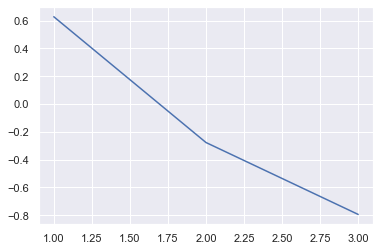

In [6787]:
dict02 = {'1': 0.628118, '2': -0.276528, '3':-0.793829 }
plt.plot([1, 2, 3], [0.628118, -0.276528,  -0.793829])

<AxesSubplot:>

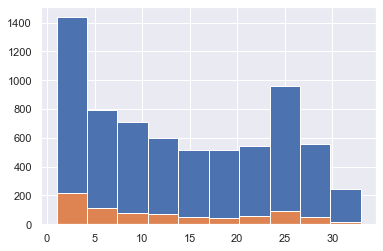

In [6788]:
train_df1_train[train_df1_train['default_12m']==0]['head_actual_age'].hist(bins = 10)
train_df1_train[train_df1_train['default_12m']==1]['head_actual_age'].hist(bins = 10)

In [6789]:
bins = [-np.inf, 3, 16,  np.inf]
labels = [ '1', '2', '3']
train_df1_train['head_actual_age_bin'] = pd.cut(train_df1_train['head_actual_age'], bins = bins, labels = labels)
d3 =calc_woe_iv(train_df1_train,'head_actual_age_bin')
d3

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
2,3327,358,2969,0.107604,0.892396,0.456633,0.431729,0.056081,0.00139663
1,1252,171,1081,0.136581,0.863419,0.218112,0.157191,0.327551,0.0199549
3,3082,255,2827,0.0827385,0.917262,0.325255,0.41108,-0.234179,0.0200985


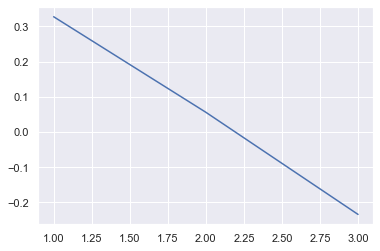

In [6790]:
dict03 = {'1': 0.327551, '2': 0.056081, '3':-0.234179}
plt.plot([1, 2, 3], [0.327551, 0.056081, -0.234179])

<AxesSubplot:>

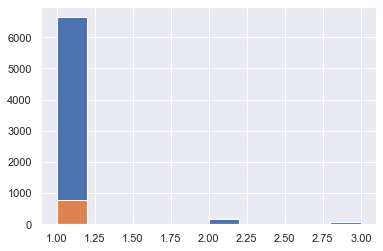

In [6791]:
train_df1_train[train_df1_train['default_12m']==0]['ul_staff_range'].hist(bins = 10)
train_df1_train[train_df1_train['default_12m']==1]['ul_staff_range'].hist(bins = 10)

In [6792]:
train_df1_train['ul_staff_range'].value_counts()

1    7415
2     181
3      65
Name: ul_staff_range, dtype: int64

In [6793]:
train_df1_train['ul_staff_range_bin'] = train_df1_train['ul_staff_range']
train_df1_train.loc[train_df1_train['ul_staff_range_bin']==2, 'ul_staff_range_bin'] = 3
d4 =calc_woe_iv(train_df1_train, 'ul_staff_range_bin')
d4

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,7415,771,6644,0.103978,0.896022,0.983418,0.966119,0.017748,0.000307024
3,246,13,233,0.0528455,0.947154,0.0165816,0.0338811,-0.714560,0.0123615


<AxesSubplot:>

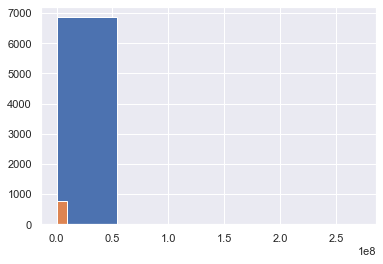

In [6794]:
train_df1_train[train_df1_train['default_12m']==0]['ul_capital_sum'].hist(bins = 5)
train_df1_train[train_df1_train['default_12m']==1]['ul_capital_sum'].hist(bins = 5)

In [6795]:
bins = [-np.inf,40000,  np.inf]
labels = [ '1', '2']
train_df1_train['ul_capital_sum_bin'] = pd.cut(train_df1_train['ul_capital_sum'], bins = bins, labels = labels)
d5 =calc_woe_iv(train_df1_train, 'ul_capital_sum_bin')
d5

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,6076,671,5405,0.110434,0.889566,0.855867,0.785953,0.085218,0.00595796
2,1585,113,1472,0.0712934,0.928707,0.144133,0.214047,-0.395461,0.0276483


In [6796]:
dict05 = {'1': 0.085218, '2': -0.395461 }

<AxesSubplot:ylabel='Frequency'>

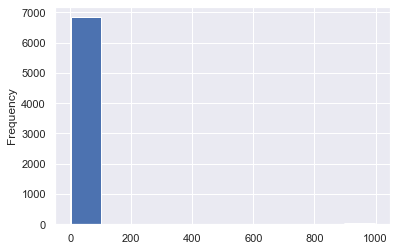

In [6797]:
train_df1_train[train_df1_train['default_12m']==0]['ul_founders_cnt'].plot.hist(bins = 10)

<AxesSubplot:ylabel='Frequency'>

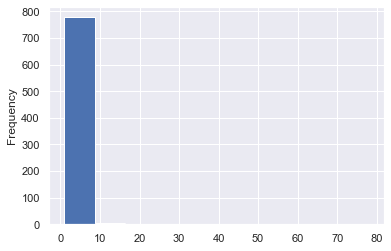

In [6798]:
train_df1_train[train_df1_train['default_12m']==1]['ul_founders_cnt'].plot.hist(bins = 10)

In [6799]:
bins = [-np.inf,1, 4,  np.inf]
labels = [ '1', '2', '3']
train_df1_train['ul_founders_cnt_bin'] = pd.cut(train_df1_train['ul_founders_cnt'], bins = bins, labels = labels)
d6 = calc_woe_iv(train_df1_train, 'ul_founders_cnt_bin')
d6

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,4510,548,3962,0.121508,0.878492,0.69898,0.576123,0.193300,0.0237481
2,2879,225,2654,0.0781521,0.921848,0.28699,0.385924,-0.296194,0.0293038
3,272,11,261,0.0404412,0.959559,0.0140306,0.0379526,-0.995096,0.0238047


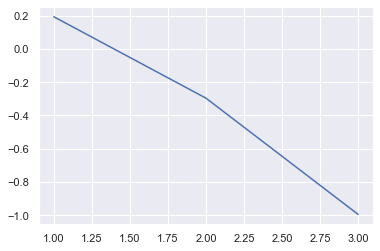

In [6800]:
dict06 = {'1': 0.193300, '2': -0.296194, '3':-0.995096}
plt.plot([1, 2, 3], [0.193300, -0.296194, -0.995096 ])

Применим функцию биннинга и замены значений на woe для тренировочного и валидационного датафреймов

In [6801]:
change_data_with_nan(X_train1)
change_data_with_nan(X_test1)

In [6802]:
X_train1.head(2)

,default_12m,bus_age_bin,ogrn_age_bin,head_actual_age_bin,ul_staff_range_bin,ul_capital_sum_bin,ul_founders_cnt_bin
4886,0,0.378404,0.628118,0.056081,0.017748,0.085218,0.193300
21123,0,-0.524445,-0.276528,0.327551,0.017748,0.085218,-0.296194


In [6803]:
X_test1.head(2)

,bus_age_bin,ogrn_age_bin,head_actual_age_bin,ul_staff_range_bin,ul_capital_sum_bin,ul_founders_cnt_bin
5163,-0.524445,-0.276528,-0.234179,0.017748,0.085218,-0.296194
25616,-0.524445,-0.276528,0.056081,0.017748,0.085218,-0.296194


Далее необходимо обучить модель и отобрать признаки
Признаки будем отбирать 2 способами:
- корреляция(больще чем 0,75)
- отбор признаков RFE
 - Еще важность признаков можно смотреть по рассчитанному IV

In [6804]:
X_train1.corr()

,default_12m,bus_age_bin,ogrn_age_bin,head_actual_age_bin,ul_staff_range_bin,ul_capital_sum_bin,ul_founders_cnt_bin
default_12m,1.000000,0.177088,0.177230,0.062277,0.029742,0.052312,0.078064
bus_age_bin,0.177088,1.000000,0.890398,0.154826,0.132938,0.067858,0.040759
ogrn_age_bin,0.177230,0.890398,1.000000,0.142518,0.145472,0.066502,0.071586
head_actual_age_bin,0.062277,0.154826,0.142518,1.000000,0.014020,-0.040199,-0.018871
ul_staff_range_bin,0.029742,0.132938,0.145472,0.014020,1.000000,0.075133,0.071018
ul_capital_sum_bin,0.052312,0.067858,0.066502,-0.040199,0.075133,1.000000,0.044072
ul_founders_cnt_bin,0.078064,0.040759,0.071586,-0.018871,0.071018,0.044072,1.000000


In [6805]:
#bus_age_bin - удалим его коррелирует с ogrn_age_bin
features1 = ['ogrn_age_bin', 'head_actual_age_bin', 'ul_capital_sum_bin', 'ul_founders_cnt_bin', 'ul_staff_range_bin'] 

In [6806]:
features_df1 = X_train1.loc[:,features1]
features_df1['default_12m'] = X_train1['default_12m']

In [6807]:
model = LogisticRegression()
rfe = RFE(model, 4)

fit = rfe.fit(features_df1.drop('default_12m',axis=1), features_df1['default_12m'])

print("Num Features: %d")  
print(fit.n_features_)

print("Selected Features: %s")  
print(fit.support_)

print("Feature Ranking: %s") 
print(fit.ranking_)

Num Features: %d
4
Selected Features: %s
[ True  True  True  True False]
Feature Ranking: %s
[1 1 1 1 2]


Преобразуем train_df1 и test_df1

In [6808]:
change_data_with_nan(train_df1)
change_data_with_nan(test_df1)

In [6809]:
features1 = [ 'ogrn_age_bin', 'head_actual_age_bin', 
             'ul_capital_sum_bin', 'ul_founders_cnt_bin', 'ul_staff_range_bin'] 
features_df1 = train_df1.loc[:,features1]
features_df1['default_12m'] = train_df1['default_12m']


In [6810]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(features_df1.drop('default_12m',axis=1),
                                                    features_df1['default_12m'],
                                                    random_state=42, shuffle=True)

logit1 = LogisticRegression(solver='lbfgs',max_iter=1000, penalty = 'l2')
cv = cross_val_score(logit1, X_train1, y_train1, cv=5, scoring='roc_auc').mean()
cv

0.6839110456268414

In [6811]:
logit1 = LogisticRegression(solver='lbfgs',max_iter=1000, penalty = 'l2').fit(X_train1, y_train1)
print("AUC на обучающей выборке : {:.3f}".format(roc_auc_score(y_train1, logit1.predict_proba(X_train1)[:, 1])))
print("AUC на контрольной выборке : {:.3f}".format(roc_auc_score(y_test1, logit1.predict_proba(X_test1)[:, 1])))

AUC на обучающей выборке : 0.686
AUC на контрольной выборке : 0.682


строим регрессию c параметром регулизации

In [6812]:
logit1 = LogisticRegression(C=0.12, penalty = 'l2',solver='lbfgs', random_state=42).fit(X_train1, y_train1)
print("AUC на обучающей выборке : {:.3f}".format(roc_auc_score(y_train1, logit1.predict_proba(X_train1)[:, 1])))
print("AUC на контрольной выборке : {:.3f}".format(roc_auc_score(y_test1, logit1.predict_proba(X_test1)[:, 1])))

AUC на обучающей выборке : 0.685
AUC на контрольной выборке : 0.684


Отбор признаков логистической регрессии с помощью случайного леса(RFE). Лучшее качество модель показала при 4 признаках. Здесь показан процесс отбора признаков, но уже финальный вариант с 4 признаками

In [6813]:
select = RFE(RandomForestClassifier(n_estimators=200, max_depth=10, random_state = 42, n_jobs = -1),
            n_features_to_select=4)
select.fit(X_train1, y_train1)
X_train1_rfe = select.transform(X_train1)
X_test1_rfe = select.transform(X_test1)

In [6814]:
mask = select.get_support()
feat_lables = X_train1.columns
for c, feature in zip(mask, feat_lables):
    print(feature, c)

ogrn_age_bin True
head_actual_age_bin True
ul_capital_sum_bin True
ul_founders_cnt_bin True
ul_staff_range_bin False


In [6815]:
features1 = [ 'ogrn_age_bin', 'head_actual_age_bin', 'ul_capital_sum_bin', 'ul_founders_cnt_bin'] 
features_df1 = train_df1.loc[:,features1]
features_df1['default_12m'] = train_df1['default_12m']
X_train1, X_test1, y_train1, y_test1 = train_test_split(features_df1.drop('default_12m',axis=1),
                                                    features_df1['default_12m'],
                                                    random_state=42, shuffle=True)

In [6816]:
logit1 = LogisticRegression().fit(X_train1, y_train1)
print("AUC на обучающей выборке : {:.3f}".format(roc_auc_score(y_train1, logit1.predict_proba(X_train1)[:, 1])))
print("AUC на контрольной выборке : {:.3f}".format(roc_auc_score(y_test1, logit1.predict_proba(X_test1)[:, 1])))

AUC на обучающей выборке : 0.686
AUC на контрольной выборке : 0.683


Настройка гиперпараметров логистической регрессии с помощью класса GRidSearchCV

In [6817]:
strat = StratifiedKFold(n_splits = 10, shuffle = True, random_state=42)
logreg_grid = LogisticRegression( penalty = 'l2', random_state=42)
param_grid = {'C': np.arange(0, 1, 0.005)}
grid_search = GridSearchCV(logreg_grid, param_grid, scoring = 'roc_auc', return_train_score=True, n_jobs = -1,
                           cv=strat)
grid_search.fit(X_train1, y_train1)
test_score = roc_auc_score(y_test1, grid_search.predict_proba(X_test1)[:, 1])
print("AUC на тестовой выборке : {:.3f}".format(test_score))
print("Наилучшее значение гиперпараметра С")
print(grid_search.best_params_)
print("Наилучшее значение AUC")
print(grid_search.best_score_)

AUC на тестовой выборке : 0.683
Наилучшее значение гиперпараметра С
{'C': 0.28500000000000003}
Наилучшее значение AUC
0.685315112893944


Подбор cutoff: посмотрим при каком значении порога модель дает большую точность

In [6818]:
porog = np.arange(0, 1.01, 0.01)
roc_auc_scores_test = []
roc_auc_scores_train = []
for i in porog:
    logit1 = LogisticRegression(C= 0.285, max_iter=1000, penalty = 'l2', random_state=17)
    logit1.fit(features_df1.drop('default_12m',axis=1), features_df1['default_12m'])
    pred_train = (logit1.predict_proba(X_train1)[:,1]>i).astype(int)
    pred_test = (logit1.predict_proba(X_test1)[:,1]>i).astype(int)
    accu_train = roc_auc_score(y_train1, pred_train)
    accu_test = roc_auc_score(y_test1, pred_test)
    roc_auc_scores_test.append(accu_test)
    roc_auc_scores_train.append(accu_train)

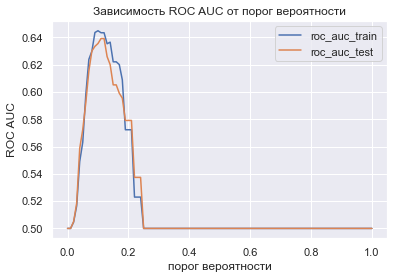

In [6819]:
plt.plot(porog, roc_auc_scores_train, label = 'roc_auc_train')
plt.plot(porog, roc_auc_scores_test, label = 'roc_auc_test')
plt.legend()
plt.title('Зависимость ROC AUC от порог вероятности') 
plt.xlabel('порог вероятности')
plt.ylabel('ROC AUC')
plt.show()

Смотрим лучшее значение в roc_auc_scores_test и какому порогу оно соответствует

In [6820]:
cutoff1 =0.11

In [6821]:
logit1 = LogisticRegression(C=0.285,max_iter=1000, penalty = 'l2', random_state=17)
logit1.fit(features_df1.drop('default_12m',axis=1), features_df1['default_12m'])
pred_train = (logit1.predict_proba(X_train1)[:,1]>cutoff1).astype(int)
pred_test = (logit1.predict_proba(X_test1)[:,1]>cutoff1).astype(int)
print(pred_train)
accu_train = accuracy_score(y_train1, pred_train)
accu_test = accuracy_score(y_test1, pred_test)

print(accu_train)
print(accu_test)

[1 0 0 ... 0 1 0]
0.6774572510116172
0.6722787783868441


Формирование ответов для части данных с пропусками

In [6822]:
answ_df1 = test_df1[['record_id']]
answ_df1['id'] = answ_df1['record_id']
answ_df1.drop('record_id',axis=1, inplace=True)
answ_df1['predict'] = (logit1.predict_proba(test_df1.loc[:,features1])[:,1]>cutoff1).astype(int)

# df2

In [6824]:
train_df2.head(2)

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,head_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,11349000.0,4523000.0,0.0,198,136,3,1,50000.0,2,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,3652000.0,0.0,0.0,185,139,8,1,300000.0,1,0


In [6825]:
train_df2.describe()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,head_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,default_12m
count,16375.000000,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,1.637500e+04,...,1.637500e+04,1.637500e+04,1.637500e+04,16375.000000,16375.000000,16375.000000,16375.000000,1.637500e+04,16375.000000,16375.000000
mean,135111.873466,7.985187e+07,7.522855e+07,7.173804e+07,2.407210e+06,1.083309e+06,4.623314e+06,-6.052549e+05,4.018059e+06,4.152474e+05,...,4.768369e+06,1.459236e+07,8.957845e+05,116.219481,91.547786,15.771725,1.170443,1.895427e+06,17.781313,0.047389
std,79599.515352,1.250218e+08,1.204088e+08,1.137228e+08,1.198818e+07,7.873977e+06,1.960520e+07,5.815716e+06,1.965486e+07,1.533049e+06,...,1.297287e+07,3.619920e+07,1.489738e+07,76.355291,43.232324,9.806939,0.415241,1.515718e+07,105.410688,0.212477
min,7.000000,0.000000e+00,-7.019840e+08,-5.072780e+08,-3.542900e+07,-1.921670e+08,-9.210000e+07,-7.581800e+07,-5.946600e+07,-1.681000e+07,...,-2.700000e+06,0.000000e+00,-2.500000e+05,8.000000,2.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000
25%,65468.500000,9.705000e+06,8.820000e+06,8.466000e+06,0.000000e+00,0.000000e+00,2.060000e+05,-9.080000e+05,1.350000e+05,0.000000e+00,...,0.000000e+00,6.460000e+05,0.000000e+00,52.000000,51.000000,6.000000,1.000000,1.000000e+04,1.000000,0.000000
50%,134141.000000,3.129100e+07,2.838600e+07,2.734400e+07,0.000000e+00,0.000000e+00,1.181000e+06,-1.240000e+05,8.050000e+05,4.100000e+04,...,3.310000e+05,3.551000e+06,0.000000e+00,99.000000,97.000000,15.000000,1.000000,1.000000e+04,1.000000,0.000000
75%,203610.500000,8.669600e+07,8.126950e+07,7.829250e+07,0.000000e+00,0.000000e+00,4.371500e+06,0.000000e+00,3.374000e+06,2.900000e+05,...,3.600000e+06,1.390850e+07,0.000000e+00,161.000000,136.000000,25.000000,1.000000,1.000000e+05,2.000000,0.000000
max,274623.000000,7.946840e+08,7.949360e+08,7.624930e+08,2.746560e+08,3.023550e+08,1.434511e+09,1.584250e+08,1.481526e+09,5.420200e+07,...,3.223740e+08,1.820521e+09,1.251578e+09,693.000000,149.000000,33.000000,3.000000,8.409151e+08,998.000000,1.000000


## Новые признаки train_df2

Создаем новые признаки(здесь есть признаки, которые создавались, но были удалены в процессе отбора признаков)

In [6826]:
# отношение доходов к расходам
train_df2['rashody'] = (train_df2['ar_total_expenses']+ train_df2['ar_sale_cost'] + 
                    train_df2['ar_selling_expenses'] + train_df2['ar_management_expenses'] + train_df2['ar_taxes'] 
                                               + train_df2['ar_revenue'] - train_df2['ar_profit_before_tax'])
test_df2['rashody'] = (test_df2['ar_total_expenses']+ test_df2['ar_sale_cost'] + 
                    test_df2['ar_selling_expenses'] + test_df2['ar_management_expenses'] + test_df2['ar_taxes'] 
                                               + test_df2['ar_revenue'] - test_df2['ar_profit_before_tax'])
train_df2.loc[train_df2['rashody']==0, 'rashody'] =1
test_df2.loc[test_df2['rashody']==0, 'rashody'] =1
#удалили во время отбора train_df2['new_1'] = train_df2['ar_sale_profit'] / train_df2['rashody']

In [6827]:
# оборотные активы
train_df2['oborotnie_activy'] = train_df2['ab_inventory'] + train_df2['ab_accounts_receivable'] + train_df2['ab_cash_and_securities'] + train_df2['ab_other_current_assets']
test_df2['oborotnie_activy'] = test_df2['ab_inventory'] + test_df2['ab_accounts_receivable'] + test_df2['ab_cash_and_securities'] + test_df2['ab_other_current_assets']
#активы всего
train_df2['activy_vsego'] = train_df2['oborotnie_activy'] + train_df2['ab_immobilized_assets']
test_df2['activy_vsego'] = test_df2['oborotnie_activy'] + test_df2['ab_immobilized_assets']
train_df2.loc[train_df2['activy_vsego']==0, 'activy_vsego']== 1
test_df2.loc[test_df2['activy_vsego']==0, 'activy_vsego']==1
# краткосрочные обязательства
train_df2['kratkosrochn_obyazatel'] = train_df2['ab_short_term_borrowing'] + train_df2['ab_accounts_payable']
test_df2['kratkosrochn_obyazatel'] = test_df2['ab_short_term_borrowing'] + test_df2['ab_accounts_payable']
train_df2.loc[train_df2['kratkosrochn_obyazatel']==0, 'kratkosrochn_obyazatel']=1
test_df2.loc[test_df2['kratkosrochn_obyazatel']==0, 'kratkosrochn_obyazatel']=1
#ДО — долгосрочные обязательства предприятия
train_df2['dolgosrochn_obyazat'] = train_df2['ab_long_term_liabilities'] + train_df2['ab_other_borrowings']
test_df2['dolgosrochn_obyazat'] = test_df2['ab_long_term_liabilities'] + test_df2['ab_other_borrowings']
train_df2.loc[train_df2['dolgosrochn_obyazat']==0, 'dolgosrochn_obyazat'] = 1
test_df2.loc[test_df2['dolgosrochn_obyazat']==0, 'dolgosrochn_obyazat'] = 1

In [6828]:
#ОА – оборотные активы , КО – краткосрочные обязательства.
# коэффициент ликвидности Ктл = ОА / КО
train_df2['coeff_likv'] = train_df2['oborotnie_activy']/train_df2['kratkosrochn_obyazatel']
test_df2['coeff_likv'] = test_df2['oborotnie_activy']/test_df2['kratkosrochn_obyazatel']

#https://rdv-it.ru/company/press-center/blog/kak-rasschitat-rentabelnost-predpriyatiya/
#Rзк=Пр/(ДО+КО)*100,где: 
#Rзк — рентабельность собственного капитала; Пр — чистая прибыль;   ar_net_profit
#ДО — долгосрочные обязательства предприятия;#КО — краткосрочные обязательства. 
#train_df2['rentab_sobstv_kapit'] = train_df2['ar_net_profit'] /(train_df2['dolgosrochn_obyazat'] + train_df2['kratkosrochn_obyazatel'])
#удалили во время отбора

In [6829]:
#https://economics.hse.ru/data/2011/11/14/1270200186/оценка%20вероятности%20дефолта%20пром%20комп.PDF
#1 Коэффициент текущей ликвидности уже есть выше
#2 Коэффициент промежуточного покрытия(срочной ликвидности)
train_df2['LIQ_QUIK'] = (train_df2['ab_cash_and_securities'] + train_df2['ab_accounts_receivable']) / train_df2['kratkosrochn_obyazatel']
test_df2['LIQ_QUIK'] = (test_df2['ab_cash_and_securities'] + test_df2['ab_accounts_receivable']) / test_df2['kratkosrochn_obyazatel']
#3коэффициент абсолютной ликвидности 
train_df2['LIQ_ABS'] = train_df2['ab_cash_and_securities']/ train_df2['kratkosrochn_obyazatel']
test_df2['LIQ_ABS'] = test_df2['ab_cash_and_securities']/ test_df2['kratkosrochn_obyazatel']
#4 Доля чистого оборотного капитала в активах - удалили во время отбора
#train_df2['NCAP_AS'] = (train_df2['oborotnie_activy'] - train_df2['ab_short_term_borrowing'] - train_df2['ab_accounts_payable'])/train_df2['activy_vsego']

#5 доля денежных средств в активах всего удалили в процессе отбора
#train_df2['CASH_AS'] = train_df2['ab_cash_and_securities'] / train_df2['activy_vsego']

#6 может быть nan в результате работы модели
train_df2['CAP_AS'] = train_df2['ab_own_capital']/train_df2['activy_vsego']
test_df2['CAP_AS'] = test_df2['ab_own_capital']/test_df2['activy_vsego']
train_df2['CAP_AS'].fillna(train_df2['CAP_AS'].median(), inplace = True)
test_df2['CAP_AS'].fillna(test_df2['CAP_AS'].median(), inplace = True)
train_df2.loc[train_df2['CAP_AS']>20000, 'CAP_AS'] = 20000
test_df2.loc[test_df2['CAP_AS']>20000, 'CAP_AS'] = 20000
train_df2.loc[train_df2['CAP_AS']<-100,'CAP_AS' ]=-382.5
test_df2.loc[test_df2['CAP_AS']<-100,'CAP_AS' ]=-382.5
#7 может быть nan в результате работы модели
#train_df2['FIN_ST'] = (train_df2['ab_own_capital'] + train_df2['dolgosrochn_obyazat'])/train_df2['activy_vsego']
#удалили во время отбора признаков

In [6830]:
train_df2.drop(columns = ['record_id'], inplace = True)

Разобьем датафрейм train_df2 на тестовую и валидационную часть

In [6831]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_df2.drop('default_12m',axis=1),
                                                    train_df2['default_12m'],
                                                    random_state=42, shuffle=True)

In [6832]:
train_df2_train = X_train2
train_df2_train['default_12m'] = y_train2

Произведем рассчет woe, iv и разбиение на бины по всем признакам
 - оставлю только несколько графиков и таблиц для примера для того, что бы не загружать файл, остальные строила анлогично
 - таблицы в любой момент можно расскоментировать и посмотреть 
 - графики можно построить по аналогии с другими признаками


In [6833]:
bins12 = [-np.inf, 0.1,0.9, 100000]
labels12 = ['1', '2', '3']
train_df2_train['CAP_AS_bin'] = pd.cut(train_df2_train['CAP_AS'], bins = bins12, labels = labels12)
d12 =calc_woe_iv(train_df2_train, 'CAP_AS_bin')
d12

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,3357,242,3115,0.0720882,0.927912,0.418685,0.266171,0.452980,0.0690858
3,2200,79,2121,0.0359091,0.964091,0.136678,0.181236,-0.282168,0.0125727
2,6724,257,6467,0.0382213,0.961779,0.444637,0.552593,-0.217365,0.023466


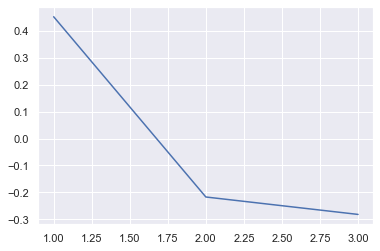

In [6834]:
dict12 = {'1': 0.452980, '2': -0.217365, '3':-0.282168}
plt.plot([1, 2, 3], [0.452980, -0.217365, -0.282168 ])

In [6835]:
bins15 = [-np.inf, 0, 0.01,np.inf] 
labels15 = [  '1', '2', '3']
train_df2_train['LIQ_ABS_bin'] = pd.cut(train_df2_train['LIQ_ABS'], bins = bins15, labels = labels15)
d15 =calc_woe_iv(train_df2_train, 'LIQ_ABS_bin')
d15

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
3,9016,338,8678,0.0374889,0.962511,0.584775,0.741519,-0.237474,0.0372226
2,2464,160,2304,0.0649351,0.935065,0.276817,0.196873,0.340798,0.0272448
1,801,80,721,0.0998752,0.900125,0.138408,0.0616081,0.809414,0.0621631


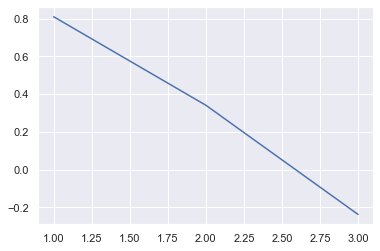

In [6836]:
dict15 = {'1': 0.809414, '2': 0.340798, '3': -0.237474}
plt.plot([1, 2, 3], [0.809414,0.340798, -0.237474])

In [6837]:
bins16 = [-np.inf, 0.02, 0.045, np.inf]
labels16 = [ '1', '2', '3']
train_df2_train['LIQ_QUIK_bin'] = pd.cut(train_df2_train['LIQ_QUIK'], bins = bins16, labels = labels16)
d16 =calc_woe_iv(train_df2_train, 'LIQ_QUIK_bin')
d16

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
3,11450,514,10936,0.0448908,0.955109,0.889273,0.934461,-0.049565,0.00223976
1,561,49,512,0.087344,0.912656,0.0847751,0.0437495,0.661522,0.0271394
2,270,15,255,0.0555556,0.944444,0.0259516,0.0217893,0.174813,0.00072762


In [6838]:
dict16 = {'1': 0.661522, '2': 0.174813, '3': -0.049565}
#plt.plot([1, 2, 3], [0.661522,0.174813, -0.049565 ])

In [6839]:
bins18 = [-np.inf,1.2, np.inf]
labels18 = [ '1', '2']
train_df2_train['coeff_likv_bin'] = pd.cut(train_df2_train['coeff_likv'], bins = bins18, labels = labels18)
d18 =calc_woe_iv(train_df2_train, 'coeff_likv_bin')
d18

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,4494,256,4238,0.0569648,0.943035,0.442907,0.362129,0.201357,0.0162651
2,7787,322,7465,0.041351,0.958649,0.557093,0.637871,-0.135403,0.0109374


In [6840]:
dict18 = {'1': 0.201357, '2': -0.135403 }

<AxesSubplot:>

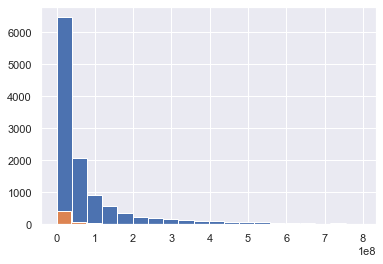

In [6841]:
train_df2_train[train_df2_train['default_12m']==0]['ar_revenue'].hist(bins = 20)
train_df2_train[train_df2_train['default_12m']==1]['ar_revenue'].hist(bins = 20)

In [6842]:
bins20 = [-np.inf,3600000, 510000000, np.inf]
labels20 = ['1', '2', '3']
train_df2_train['ar_revenue_bin'] = pd.cut(train_df2_train['ar_revenue'], bins = bins20, labels = labels20)
d20 =calc_woe_iv(train_df2_train, 'ar_revenue_bin')
d20

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
2,10446,412,10034,0.0394409,0.960559,0.712803,0.857387,-0.184685,0.0267025
1,1565,165,1400,0.105431,0.894569,0.285467,0.119627,0.869745,0.144238
3,270,1,269,0.0037037,0.996296,0.0017301,0.0229856,-2.586685,0.0549812


In [6843]:
dict20 = {'1': 0.869745, '2': -0.184685, '3': -2.586685 }
#plt.plot([1, 2, 3], [0.869745, -0.184685, -2.586685 ])

In [6844]:
bins23 = [-np.inf,0, 42000000,np.inf]# 
labels23 = ['1', '2', '3']
train_df2_train['ar_selling_expenses_bin'] = pd.cut(train_df2_train['ar_selling_expenses'], bins = bins23, labels = labels23)
d23 =calc_woe_iv(train_df2_train, 'ar_selling_expenses_bin')
d23

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,10387,504,9883,0.0485222,0.951478,0.871972,0.844484,0.032032,0.000880482
2,1686,72,1614,0.0427046,0.957295,0.124567,0.137913,-0.101778,0.00135832
3,208,2,206,0.00961538,0.990385,0.00346021,0.0176023,-1.626702,0.023005


In [6845]:
dict23 = {'1': 0.032032, '2':  -0.101778, '3':-1.626702 }
#plt.plot([1, 2, 3], [0.032032, -0.101778, -1.626702])

In [6846]:
bins27 = [-np.inf, 60000,900000, np.inf]
labels27 = ['1', '2', '3']
train_df2_train['ar_profit_before_tax_bin'] = pd.cut(train_df2_train['ar_profit_before_tax'], bins = bins27, labels = labels27)
d27 =calc_woe_iv(train_df2_train, 'ar_profit_before_tax_bin')
d27

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
2,4072,247,3825,0.0606582,0.939342,0.427336,0.326839,0.268101,0.0269432
3,5907,154,5753,0.0260708,0.973929,0.266436,0.491583,-0.612498,0.137902
1,2302,177,2125,0.0768897,0.92311,0.306228,0.181577,0.522649,0.0651488


In [6847]:
dict27 = {'1': 0.522649, '2': 0.268101 , '3': -0.612498 }
#plt.plot([1, 2, 3], [0.522649, 0.268101, -0.612498])

In [6848]:
bins28 = [-np.inf,70000, 750000, np.inf]
labels28 = ['1', '2', '3']
train_df2_train['ar_taxes_bin'] = pd.cut(train_df2_train['ar_taxes'], bins = bins28, labels = labels28)
d28 =calc_woe_iv(train_df2_train, 'ar_taxes_bin')
d28

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
2,3860,160,3700,0.0414508,0.958549,0.276817,0.316158,-0.132888,0.00522802
1,6879,403,6476,0.0585841,0.941416,0.697232,0.553362,0.231105,0.0332489
3,1542,15,1527,0.00972763,0.990272,0.0259516,0.130479,-1.614983,0.168811


In [6849]:
dict28 = {'1': 0.231105, '2':-0.132888 , '3': -1.614983 }
#plt.plot([1, 2, 3], [0.231105,-0.132888,-1.614983])

<AxesSubplot:>

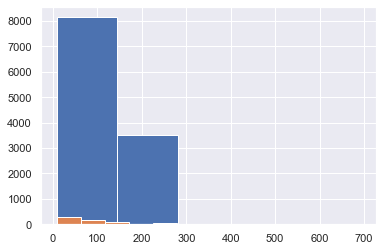

In [6850]:
train_df2_train[train_df2_train['default_12m']==0]['bus_age'].hist(bins = 5)
train_df2_train[train_df2_train['default_12m']==1]['bus_age'].hist(bins = 5)

In [6851]:
bins44 = [-np.inf, 57, 200, np.inf]
labels44 = ['1', '2', '3']
train_df2_train['bus_age_bin'] = pd.cut(train_df2_train['bus_age'], bins = bins44, labels = labels44)
d44 =calc_woe_iv(train_df2_train, 'bus_age_bin')
d44

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
2,6582,266,6316,0.0404132,0.959587,0.460208,0.539691,-0.159318,0.0126631
1,3433,268,3165,0.0780658,0.921934,0.463668,0.270443,0.539105,0.104168
3,2266,44,2222,0.0194175,0.980583,0.0761246,0.189866,-0.913947,0.103953


In [6852]:
dict44 = {'1':0.539105, '2':-0.159318, '3':-0.913947}
#plt.plot([1, 2, 3], [0.539105, -0.159318,-0.913947])

In [6853]:
bins46 = [-np.inf,15, np.inf]
labels46 = ['1', '2']
train_df2_train['head_actual_age_bin'] = pd.cut(train_df2_train['head_actual_age'], bins = bins46, labels = labels46)
d46 =calc_woe_iv(train_df2_train, 'head_actual_age_bin')
d46

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
2,6084,261,5823,0.0428994,0.957101,0.451557,0.497565,-0.097024,0.00446384
1,6197,317,5880,0.0511538,0.948846,0.548443,0.502435,0.087616,0.00403102


In [6854]:
dict46 = {'1': 0.087616, '2':-0.097024}

In [6855]:
bins48 = [-np.inf,21000, np.inf]
labels48 = ['1', '2']
train_df2_train['ul_capital_sum_bin'] = pd.cut(train_df2_train['ul_capital_sum'], bins = bins48, labels = labels48)
d48 =calc_woe_iv(train_df2_train, 'ul_capital_sum_bin')
#d48

In [6856]:
dict48 = {'1': 0.110026, '2':-0.260274}

In [6857]:
bins49 = [-np.inf,1,15, np.inf]
labels49 = ['1', '2', '3']
train_df2_train['ul_founders_cnt_bin'] = pd.cut(train_df2_train['ul_founders_cnt'], bins = bins49, labels = labels49)

d49 =calc_woe_iv(train_df2_train, 'ul_founders_cnt_bin')
d49

,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
2,4830,172,4658,0.0356108,0.964389,0.297578,0.398018,-0.290820,0.0292099
1,6821,394,6427,0.0577628,0.942237,0.681661,0.549175,0.216114,0.028632
3,630,12,618,0.0190476,0.980952,0.0207612,0.052807,-0.933555,0.0299165


In [6858]:
dict49 = {'1':0.216114, '2':-0.290820, '3':-0.933555}
#plt.plot([1, 2, 3], [0.216114,-0.290820, -0.933555 ])

Применим функцию биннинга и замены значений на woe для тренировочного и валидационного датафреймов

In [6859]:
change_data(X_train2)
change_data(X_test2)

In [6860]:
X_train2.head(2)

,default_12m,CAP_AS_bin,LIQ_ABS_bin,LIQ_QUIK_bin,coeff_likv_bin,ar_revenue_bin,ar_selling_expenses_bin,ar_profit_before_tax_bin,ar_taxes_bin,bus_age_bin,head_actual_age_bin,ul_capital_sum_bin,ul_founders_cnt_bin
8493,0,0.45298,-0.237474,-0.049565,0.201357,-0.184685,0.032032,0.268101,-0.132888,-0.159318,-0.097024,0.110026,-0.290820
12209,0,0.45298,-0.237474,-0.049565,0.201357,-0.184685,0.032032,0.268101,-0.132888,0.539105,0.087616,0.110026,0.216114


In [6861]:
X_test2.head(2)

,CAP_AS_bin,LIQ_ABS_bin,LIQ_QUIK_bin,coeff_likv_bin,ar_revenue_bin,ar_selling_expenses_bin,ar_profit_before_tax_bin,ar_taxes_bin,bus_age_bin,ul_capital_sum_bin,ul_founders_cnt_bin,head_actual_age_bin
3142,-0.217365,-0.237474,-0.049565,-0.135403,-0.184685,-0.101778,-0.612498,-0.132888,0.539105,0.110026,-0.290820,0.087616
30400,-0.217365,0.340798,-0.049565,-0.135403,-0.184685,0.032032,0.522649,0.231105,-0.159318,0.110026,0.216114,0.087616


Аналогично с первым датафреймом
обучим модель и отберем признаки
Признаки будем отбирать 2 способами:
- корреляция(больще чем 0,75)
- отбор признаков RFE
(Еще важность признаков можно смотреть по рассчитанному IV)

Cильно коррелируют(больше 0.75)
(уже убрали)
coeff_likv_bin 
bus_age_bin 

In [6862]:
X_train2.corr()

,default_12m,CAP_AS_bin,LIQ_ABS_bin,LIQ_QUIK_bin,coeff_likv_bin,ar_revenue_bin,ar_selling_expenses_bin,ar_profit_before_tax_bin,ar_taxes_bin,bus_age_bin,head_actual_age_bin,ul_capital_sum_bin,ul_founders_cnt_bin
default_12m,1.000000,0.072564,0.082916,0.042221,0.035514,0.093495,0.024686,0.098632,0.074234,0.095784,0.019488,0.034667,0.058156
CAP_AS_bin,0.072564,1.000000,0.057987,-0.050122,0.543740,0.048112,-0.008663,0.346239,0.137722,0.348376,-0.018111,0.217292,0.159786
LIQ_ABS_bin,0.082916,0.057987,1.000000,0.394089,0.098761,0.111362,0.002744,0.120514,0.075898,0.051693,0.015699,0.005633,0.059220
LIQ_QUIK_bin,0.042221,-0.050122,0.394089,1.000000,0.000111,0.169195,0.034632,0.136288,0.118607,0.017545,0.029746,-0.046094,0.063601
coeff_likv_bin,0.035514,0.543740,0.098761,0.000111,1.000000,0.021916,-0.040184,0.247480,0.057967,0.220021,0.002477,0.156977,0.088932
ar_revenue_bin,0.093495,0.048112,0.111362,0.169195,0.021916,1.000000,0.255221,0.349588,0.317878,0.171688,-0.003240,0.108441,0.090345
ar_selling_expenses_bin,0.024686,-0.008663,0.002744,0.034632,-0.040184,0.255221,1.000000,0.099844,0.176668,0.063431,-0.018670,0.060612,0.055309
ar_profit_before_tax_bin,0.098632,0.346239,0.120514,0.136288,0.247480,0.349588,0.099844,1.000000,0.427282,0.246474,-0.022195,0.145970,0.178206
ar_taxes_bin,0.074234,0.137722,0.075898,0.118607,0.057967,0.317878,0.176668,0.427282,1.000000,0.139880,-0.000958,0.073068,0.081976
bus_age_bin,0.095784,0.348376,0.051693,0.017545,0.220021,0.171688,0.063431,0.246474,0.139880,1.000000,-0.066368,0.281637,0.311599


In [6863]:
X_train2.columns

Index(['default_12m', 'CAP_AS_bin', 'LIQ_ABS_bin', 'LIQ_QUIK_bin',
       'coeff_likv_bin', 'ar_revenue_bin', 'ar_selling_expenses_bin',
       'ar_profit_before_tax_bin', 'ar_taxes_bin', 'bus_age_bin',
       'head_actual_age_bin', 'ul_capital_sum_bin', 'ul_founders_cnt_bin'],
      dtype='object')

Здесь, так же как и в случае первого датафрейма показан процесс отбора признаков, параметров и обучения модели на финальных признаках. Признаки, которые были отсеяны тут не используются

In [6864]:
features2 = ['CAP_AS_bin', 'LIQ_ABS_bin', 'LIQ_QUIK_bin',
       'coeff_likv_bin', 'ar_revenue_bin','ar_selling_expenses_bin','ar_profit_before_tax_bin',
       'ar_taxes_bin','bus_age_bin','ul_capital_sum_bin',
       'ul_founders_cnt_bin', 'head_actual_age_bin']

Преобразуем train_df2 и test_df2

In [6865]:
change_data(train_df2)
change_data(test_df2)

In [6866]:
features_df2 = train_df2.loc[:,features2]
features_df2['default_12m'] = train_df2['default_12m']

In [6867]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features_df2.drop('default_12m',axis=1),
                                                    features_df2['default_12m'],
                                                    random_state=42, shuffle=True)

logit2 = LogisticRegression(solver='lbfgs',max_iter=1000, penalty = 'l2', random_state=42)
cv = cross_val_score(logit2, X_train2, y_train2, cv=5, scoring='roc_auc').mean()
cv

0.6983578926056857

In [6868]:
logit2 = LogisticRegression(solver='lbfgs',max_iter=100, penalty = 'l2', random_state=42).fit(X_train2, y_train2)
print("AUC на обучающей выборке : {:.3f}".format(roc_auc_score(y_train2, logit2.predict_proba(X_train2)[:, 1])))
print("AUC на контрольной выборке : {:.3f}".format(roc_auc_score(y_test2, logit2.predict_proba(X_test2)[:, 1])))

AUC на обучающей выборке : 0.706
AUC на контрольной выборке : 0.707


строим регрессию c параметром регулизации

In [6869]:
logit2 = LogisticRegression(C=0.12, penalty = 'l2',solver='lbfgs', random_state=42).fit(X_train2, y_train2)
print("AUC на обучающей выборке : {:.3f}".format(roc_auc_score(y_train2, logit2.predict_proba(X_train2)[:, 1])))
print("AUC на контрольной выборке : {:.3f}".format(roc_auc_score(y_test2, logit2.predict_proba(X_test2)[:, 1])))

AUC на обучающей выборке : 0.705
AUC на контрольной выборке : 0.706


Отбор признаков логистической регрессии с помощью случайного леса(RFE). Лучшее качество модель показала при _ признаках

In [6870]:
n = 12

In [6871]:
select2 = RFE(RandomForestClassifier(n_estimators=200, max_depth=10, random_state = 42, n_jobs = -1),
            n_features_to_select=n)
select2.fit(X_train2, y_train2)

mask2 = select2.get_support()
feat_lables2 = X_train2.columns
for c, feature in zip(mask2, feat_lables2):
    print(feature, c)

CAP_AS_bin True
LIQ_ABS_bin True
LIQ_QUIK_bin True
coeff_likv_bin True
ar_revenue_bin True
ar_selling_expenses_bin True
ar_profit_before_tax_bin True
ar_taxes_bin True
bus_age_bin True
ul_capital_sum_bin True
ul_founders_cnt_bin True
head_actual_age_bin True


In [6874]:
features2 = ['CAP_AS_bin', 'LIQ_ABS_bin', 'LIQ_QUIK_bin',
       'coeff_likv_bin', 'ar_revenue_bin','ar_selling_expenses_bin','ar_profit_before_tax_bin',
       'ar_taxes_bin','bus_age_bin','ul_capital_sum_bin',
       'ul_founders_cnt_bin', 'head_actual_age_bin'] 
features_df2 = train_df2.loc[:,features2]
features_df2['default_12m'] = train_df2['default_12m']
X_train2, X_test2, y_train2, y_test2 = train_test_split(features_df2.drop('default_12m',axis=1),
                                                    features_df2['default_12m'],
                                                    random_state=42, shuffle=True)

In [6876]:
logit2 = LogisticRegression().fit(X_train2, y_train2)
print("AUC на обучающей выборке : {:.3f}".format(roc_auc_score(y_train2, logit2.predict_proba(X_train2)[:, 1])))
print("AUC на контрольной выборке : {:.3f}".format(roc_auc_score(y_test2, logit2.predict_proba(X_test2)[:, 1])))

AUC на обучающей выборке : 0.706
AUC на контрольной выборке : 0.707


Настройка гиперпараметров логистической регрессии с помощью класса GRidSearchCV

In [6877]:
strat2 = StratifiedKFold(n_splits = 10, shuffle = True, random_state=42)
logreg_grid2 = LogisticRegression( penalty = 'l2', random_state=42)
param_grid2 = {'C': np.arange(0, 1, 0.005)}
grid_search2 = GridSearchCV(logreg_grid2, param_grid2, scoring = 'roc_auc', return_train_score=True, n_jobs = -1,
                           cv=strat2)
grid_search2.fit(X_train2, y_train2)
test_score2 = roc_auc_score(y_test2, grid_search2.predict_proba(X_test2)[:, 1])
print("AUC на тестовой выборке : {:.3f}".format(test_score2))
print("Наилучшее значение гиперпараметра С")
print(grid_search2.best_params_)
print("Наилучшее значение AUC")
print(grid_search2.best_score_)

AUC на тестовой выборке : 0.706
Наилучшее значение гиперпараметра С
{'C': 0.16}
Наилучшее значение AUC
0.7003258377368798


Подбор cutoff: посмотрим при каком значении порога модель дает большую точ

In [6878]:
C2 = 0.16

In [6879]:
porog = np.arange(0, 1.01, 0.01)
roc_auc_scores_test = []
roc_auc_scores_train = []
for i in porog:
    logit2 = LogisticRegression(C= C2, max_iter=1000, penalty = 'l2', random_state=17)
    logit2.fit(features_df2.drop('default_12m',axis=1), features_df2['default_12m'])
    pred_train = (logit2.predict_proba(X_train2)[:,1]>i).astype(int)
    pred_test = (logit2.predict_proba(X_test2)[:,1]>i).astype(int)
    accu_train = roc_auc_score(y_train2, pred_train)
    accu_test = roc_auc_score(y_test2, pred_test)
    roc_auc_scores_test.append(accu_test)
    roc_auc_scores_train.append(accu_train)

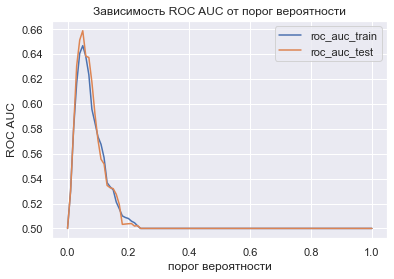

In [6880]:
plt.plot(porog, roc_auc_scores_train, label = 'roc_auc_train')
plt.plot(porog, roc_auc_scores_test, label = 'roc_auc_test')
plt.legend()
plt.title('Зависимость ROC AUC от порог вероятности') 
plt.xlabel('порог вероятности')
plt.ylabel('ROC AUC')
plt.show()

In [6883]:
#roc_auc_scores_test

In [6557]:
porog

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

максимальный roc_auc_scores_test при пороге 0.05

In [6882]:
cutoff2 =0.05

In [6884]:
logit2 = LogisticRegression(C=C2,max_iter=1000, penalty = 'l2', random_state=17)
logit2.fit(features_df2.drop('default_12m',axis=1), features_df2['default_12m'])
pred_train = (logit2.predict_proba(X_train2)[:,1]>cutoff2).astype(int)
pred_test = (logit2.predict_proba(X_test2)[:,1]>cutoff2).astype(int)
print(pred_train)
accu_train = accuracy_score(y_train2, pred_train)
accu_test = accuracy_score(y_test2, pred_test)

print(accu_train)
print(accu_test)

[0 1 0 ... 1 0 1]
0.6606139565181989
0.6607230092818759


In [6885]:
answ_df2 = test_df2[['record_id']]
answ_df2['id'] = answ_df2['record_id']

answ_df2.drop('record_id',axis=1, inplace=True)
answ_df2['predict'] = (logit2.predict_proba(test_df2.loc[:,features2])[:,1]>cutoff2).astype(int)

### Формирование файла с ответом

In [6886]:
answ_df = pd.concat([answ_df1, answ_df2], ignore_index = True)
test_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-test.csv', sep=';')
answ_df['id']=test_df['record_id']
answ_df.to_csv('PD-submit23-3.csv',index=False, sep=';')

In [6887]:
answ_df

,id,predict
0,196,0
1,1196,0
2,2813,1
3,4385,1
4,6479,1
...,...,...
195,265577,0
196,266648,0
197,266849,1
198,267566,0


Комментарии.
Качество модели можно улучшить, добавив новые признаки.
Новые признаки можно сделать следующим образом:
 - простыми операциями - деление, умножение, сложение и вычитание (возможно сразу несколько признаков одновоременно)
 - возведение в степень

Но в силу того, что не смогла найти библиотеку, которая делает binning/woe преобразования, то оценивать качество разбиения приходилось вручную.
Поэтому сами признаки могут обладать на столь высоким качеством предсказания

Так как целевая переменная имеет несбалансированные классы, попробовала еще сдлеать балансировку классов с помощью BorderlineSMOTE(код ниже), но прироста качества модели не было

In [ ]:
#smote
from imblearn.over_sampling import BorderlineSMOTE
bs = BorderlineSMOTE(random_state=152, n_jobs = -1)
X_smote, y_smote = bs.fit_sample(X_train1,y_train1 )
logit1 = LogisticRegression().fit(X_smote, y_smote)
print("AUC на обучающей выборке : {:.3f}".format(roc_auc_score(y_smote, logit1.predict_proba(X_smote)[:, 1])))
print("AUC на контрольной выборке : {:.3f}".format(roc_auc_score(y_test1, logit1.predict_proba(X_test1)[:, 1])))